<a href="https://colab.research.google.com/github/Dmitri9149/TensorFlow-PyTorch-Recurrent-NeuralNetworks/blob/main/PyTorch_%3E_Sequence_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [604]:
# -U: Upgrade all packages to the newest available version
!pip install -U d2l
from IPython import display
from IPython.display import set_matplotlib_formats
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn
from matplotlib import pyplot as plt

Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.16.0)


The work is for experimenting with sequence models with PyTorch.
The work and code in it is based on the d2l.ai project http://d2l.ai/index.html, it is for the better PyTorch and Tesnorflow learning/understanding.
My comments are with 3 -# : ### 

We will generate some sequence data and try to predict next step data basing on the n previous steps.

In [605]:
T = 1000 ## will consider 1000 points in time 
time = torch.arange(1, T+1, dtype = torch.float32)
y = torch.sin(0.01 * time) + torch.normal(0.00, 0.2, (T,))

In [606]:
y.shape

torch.Size([1000])

In [607]:
print(y[0:20])

tensor([ 0.2614, -0.0499,  0.0750, -0.0152, -0.3771,  0.0848, -0.1220, -0.0391,
         0.0792,  0.0551, -0.1248,  0.3880, -0.0022,  0.3741,  0.1207,  0.0822,
         0.0395,  0.1372,  0.0708, -0.3518])


In [608]:
### from d2l.ai
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

In [609]:
## from d2l.ai
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [610]:
## modified, based on d2l.ai
def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
## use 'svg' format (not 'png')
    set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize

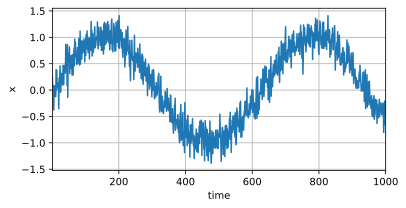

In [611]:
### making plot
plot(time, y, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [612]:
### tau is number of sequential data points in time we 
### use for the ahead predictions, if we took the points at time t : 
### x(t-tau+1).....x(t) -> we can make 1-step prediction -> prediction 
### at time t+1 ; 
### or we can make k-step ahead prediction -> prediction at time t+k using 
### the all the previous predition : 1-step, 2-step, etc...
### this is what 

tau = 4
features = torch.zeros((T-tau, tau))
features.shape

torch.Size([996, 4])

In [613]:
### from d2l.ai
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

In [614]:
for i in range(tau):
    features[:, i] = y[i: T - tau + i]
labels = reshape(y[tau:], (-1, 1))

In [615]:
labels.shape

torch.Size([996, 1])

In [616]:
### from d2l.ai
### prepare Dataset from our tensors
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [617]:
### will use only 600 points from 1000 (actually 604) 
### it is because we are going to make experiments where we will use predictions 
### to predict another predictions (after first 604 points)
batch_size, n_train = 16, 600
# Only the first `n_train` examples are used for training
train_iter = load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [618]:
### we have 4 features (4 consecutive points in the past) and 925 records in our training set:
### example : we have (x0, x1, v2,x3) -> predict x5
###         ; we have (x1, x2, x3, x4) -> predict x6

In [619]:
### below we construct and initialize simple network for predictions

In [620]:
### from d2l.ai
# Function for initializing the weights of the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

In [621]:
loss = nn.MSELoss()

In [622]:
net = nn.Sequential(nn.Linear(4, 10),
                    nn.ReLU(),
                    nn.Linear(10, 1))

In [623]:
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [624]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = torch.zeros(n)

    def add(self, *args):
        self.data = torch.as_tensor([a + float(b) for a, b in zip(self.data, args)])

    def reset(self):
        self.data = torch.zeros(n)

    def __getitem__(self, idx):
        return self.data[idx]

In [625]:
### from d2l.ai
def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = reshape(y, out.shape)
        l = loss(out, y)
        metric.add(reduce_sum(l), size(l))
    return metric[0] / metric[1]

In [626]:
### from d2l.ai
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

In [627]:
### Train the model
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.067531
epoch 2, loss: 0.051248
epoch 3, loss: 0.051350
epoch 4, loss: 0.055794
epoch 5, loss: 0.048663


In [628]:
### Model predictions

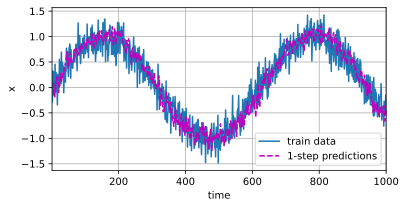

In [629]:
### we use tau(t) train points to predict next poin after the tau(t) points 
###  tau(t) -> the data at t+1 , where we designate symbolically as tau(t) the 
### tau previous points from time t
onestep_preds = net(features)
plot([time, time[tau:]], [numpy(x), numpy(onestep_preds)], 'time',
         'x', legend=['train data', '1-step predictions'], xlim=[1, 1000], figsize=(6, 3))

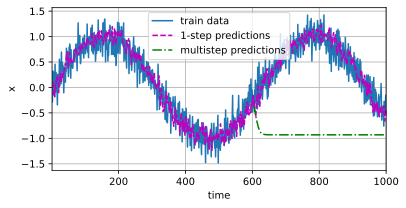

In [630]:
### we may use tau(t) from some time point , let us t = say 604
### to calculate prediction at t+1, using the prediction and the trained 
### model to calculte prediction at t+2 (where we will use the prediction at t+1)
### etc... it will give us the green line
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        reshape(indirect_preds[i - tau: i], (1, -1)))

plot([time, time[tau:], time[n_train + tau:]],
         [numpy(x), numpy(onestep_preds),
          numpy(multistep_preds[n_train + tau:])], 'time',
         'x', legend=['train data', '1-step predictions', 'multistep predictions'],
         xlim=[1, 1000], figsize=(6, 3))

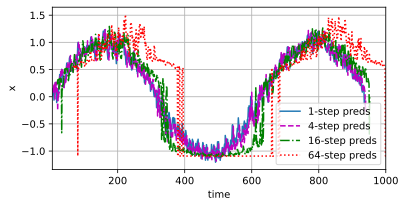

In [631]:
###  we may try to calculate using tau(t) predictions at time t +1 , 
### for all t
### using predictions for t+1 (1-step predictions) 
### we can calculate predictions at t+2 from tau(t) for all t , 
### but in the case we will use 1-step predictions as 'features', 
### i.e we will calculate 2-step repdictions on the basis of 1-step predictions
### we can continue the recursive process and calculate 1-step, 4-step, 16-step, 64-step 
### ahead predictions; but the quality of predictions will quickly decrease with 
### the number of ahead steps

### from d2l.ai
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = reshape(net(features[:, i - tau: i]), -1)

steps = (1, 4, 16, 64)
plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [numpy(features[:, tau + i - 1]) for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))